# Remote Sensing Analysis and Cover Classification of Mangrove Forest in Baie de Grand-Pierre, Artibonite, Haiti

In [1]:
import os
import torch
import itertools

import cv2 as cv
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import earthpy.plot as ep
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from kmeans_pytorch import kmeans, kmeans_predict
from matplotlib import colors as colors_mat
import matplotlib.patches as mpatches

AOI Selection

In [2]:
aoi_list = ['coast_NW', 'coast_N', 'horn', 'coast_W', 'marsh_E', 'marsh_W']
#aoi_list = ['west','east','barrier', 'coast_marsh_S']

def aoi_path(name):
    return '../shapefiles/'+name+'.shp'

## PlanetLabs Data Analysis

### Planet Data GeoTIFFs acquisition

In [3]:
dir = '../Planet/'
#dir = '../Planet_Caracol/'
times = []
sites = []
resSites = []
unmasked_sites = []
for area in aoi_list:
    unmasked_obs = []
    obs = []
    res = []
    aoi = gpd.read_file(aoi_path(area))
    for entry in os.scandir(dir):
        times.append(entry.path)
        ob = rxr.open_rasterio(entry.path).rio.clip(aoi.geometry, from_disk=True).squeeze()
        ob_copy = rxr.open_rasterio(entry.path).rio.clip(aoi.geometry, from_disk=True).squeeze()
        res.append(ob.rio.resolution()[0])
        obs.append(ob)
        unmasked_obs.append(ob_copy)
    sites.append(obs)
    unmasked_sites.append(unmasked_obs)
    resSites.append(res)

### NDWI Masking

In [ ]:
# NDWI = (green - nir)/(green + nir) McFeeters (1996)

#NDWI masks
ndwi_masks = []
for site in sites:
    for obs in site:
        try:
            ndwi = (obs[1]-obs[4])/(obs[1]+obs[4])
        except:
            ndwi = (obs[1]-obs[3])/(obs[1]+obs[3])
        ndwi_masks.append(ndwi)

# Masking water out of observations
count = 0
mask_count = 0
for site in sites:
    for i,obs in enumerate(site):
        for j,band in enumerate(obs):
            ### NDWI Masking Interpretation
            band = np.ma.masked_where(ndwi_masks[mask_count] > 0, band)
            obs[j] = np.nan_to_num(band)
            ###
            count+=1
            #obs[j] = np.nan_to_num(band)        
        mask_count+=1    

fig, axs = plt.subplots(3,2, figsize=(15,15), dpi=200)
fig.suptitle('Visualization of Areas of Interest with Water Masked, 2022 (PlanetLabs Data)')
axs = list(itertools.chain.from_iterable(axs))
for i, site in enumerate(sites):
    ep.plot_rgb(sites[i][0], rgb=[2,1,0], title=aoi_list[i], stretch=True,
            str_clip=1.5, ax=axs[i])
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
plt.axis('off')
fig.patch.set_facecolor('xkcd:white')
plt.tight_layout(h_pad=0)

plt.show()

### K-means Clustering and Classification

Data Reshaping into Vectors for ML use

In [4]:
reshapedSites = []
for site in sites:
    acqVecs = []
    reshapedVecs = []
    shapes = []
    for ob in site:
        shapes.append(ob.shape)
        acq = [band.values.reshape(((band.shape)[0])*((band.shape)[1]), 1) for band in ob]
        acqVecs.append(acq)
    for i, acq in enumerate(acqVecs):
        resh = np.array(acq).reshape(shapes[i][0], shapes[i][1]*shapes[i][2]).transpose()
        reshapedVecs.append(resh)
    reshapedSites.append(reshapedVecs)

#### Segmentation and Clustering

Setting device to CUDA (GPU) if available

In [5]:
# set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Training

In [6]:
# Segmenting through k-means
modelSites = []

# Training
print('Entering site...')
for reshapedVecs in tqdm(reshapedSites):
    models = []

    for i, resh in enumerate(reshapedVecs):
        x = torch.from_numpy(resh)
        if i == 0:

            cluster_x, cluster_center = kmeans(X=x, num_clusters=4, distance='euclidean', device=device)
            models.append(cluster_center)
        elif i == 4:

            cluster_x, cluster_center = kmeans(X=x, num_clusters=4, distance='euclidean', device=device)
            models.append(cluster_center)
    modelSites.append(models)


Entering site...


  0%|          | 0/6 [00:00<?, ?it/s]

running k-means on cuda..


[running kmeans]: 22it [00:00, 29.90it/s, center_shift=0.000000, iteration=22, tol=0.000100]


running k-means on cuda..


[running kmeans]: 53it [00:04, 12.87it/s, center_shift=0.000000, iteration=53, tol=0.000100]


running k-means on cuda..


[running kmeans]: 31it [00:02, 14.11it/s, center_shift=0.000000, iteration=31, tol=0.000100]


running k-means on cuda..


[running kmeans]: 43it [00:07,  5.45it/s, center_shift=0.000090, iteration=43, tol=0.000100]


running k-means on cuda..


[running kmeans]: 19it [00:02,  9.12it/s, center_shift=0.000086, iteration=19, tol=0.000100]


running k-means on cuda..


[running kmeans]: 53it [00:15,  3.41it/s, center_shift=0.000033, iteration=53, tol=0.000100]


running k-means on cuda..


[running kmeans]: 18it [00:00, 21.47it/s, center_shift=0.000000, iteration=18, tol=0.000100]


running k-means on cuda..


[running kmeans]: 32it [00:03,  8.82it/s, center_shift=0.000052, iteration=32, tol=0.000100]


running k-means on cuda..


[running kmeans]: 55it [00:03, 15.64it/s, center_shift=0.000089, iteration=55, tol=0.000100]


running k-means on cuda..


[running kmeans]: 27it [00:04,  6.29it/s, center_shift=0.000097, iteration=27, tol=0.000100]


running k-means on cuda..


[running kmeans]: 20it [00:00, 22.00it/s, center_shift=0.000000, iteration=20, tol=0.000100]


running k-means on cuda..


[running kmeans]: 33it [00:03,  9.68it/s, center_shift=0.000035, iteration=33, tol=0.000100]


In [32]:
# Predicting 
clusterSites = []
for i, site in enumerate(sites):
    clusters =[]
    for j, resh in enumerate(reshapedSites[i]):
        y = torch.from_numpy(resh)
        try:
            cluster_y = kmeans_predict(y, modelSites[i][0], 'euclidean', device=device)
        except:
            cluster_y = kmeans_predict(y, modelSites[i][1], 'euclidean', device=device)
        clusters.append(cluster_y)
    clusterSites.append(clusters)

predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..
predicting on cuda..


Blurring Sites

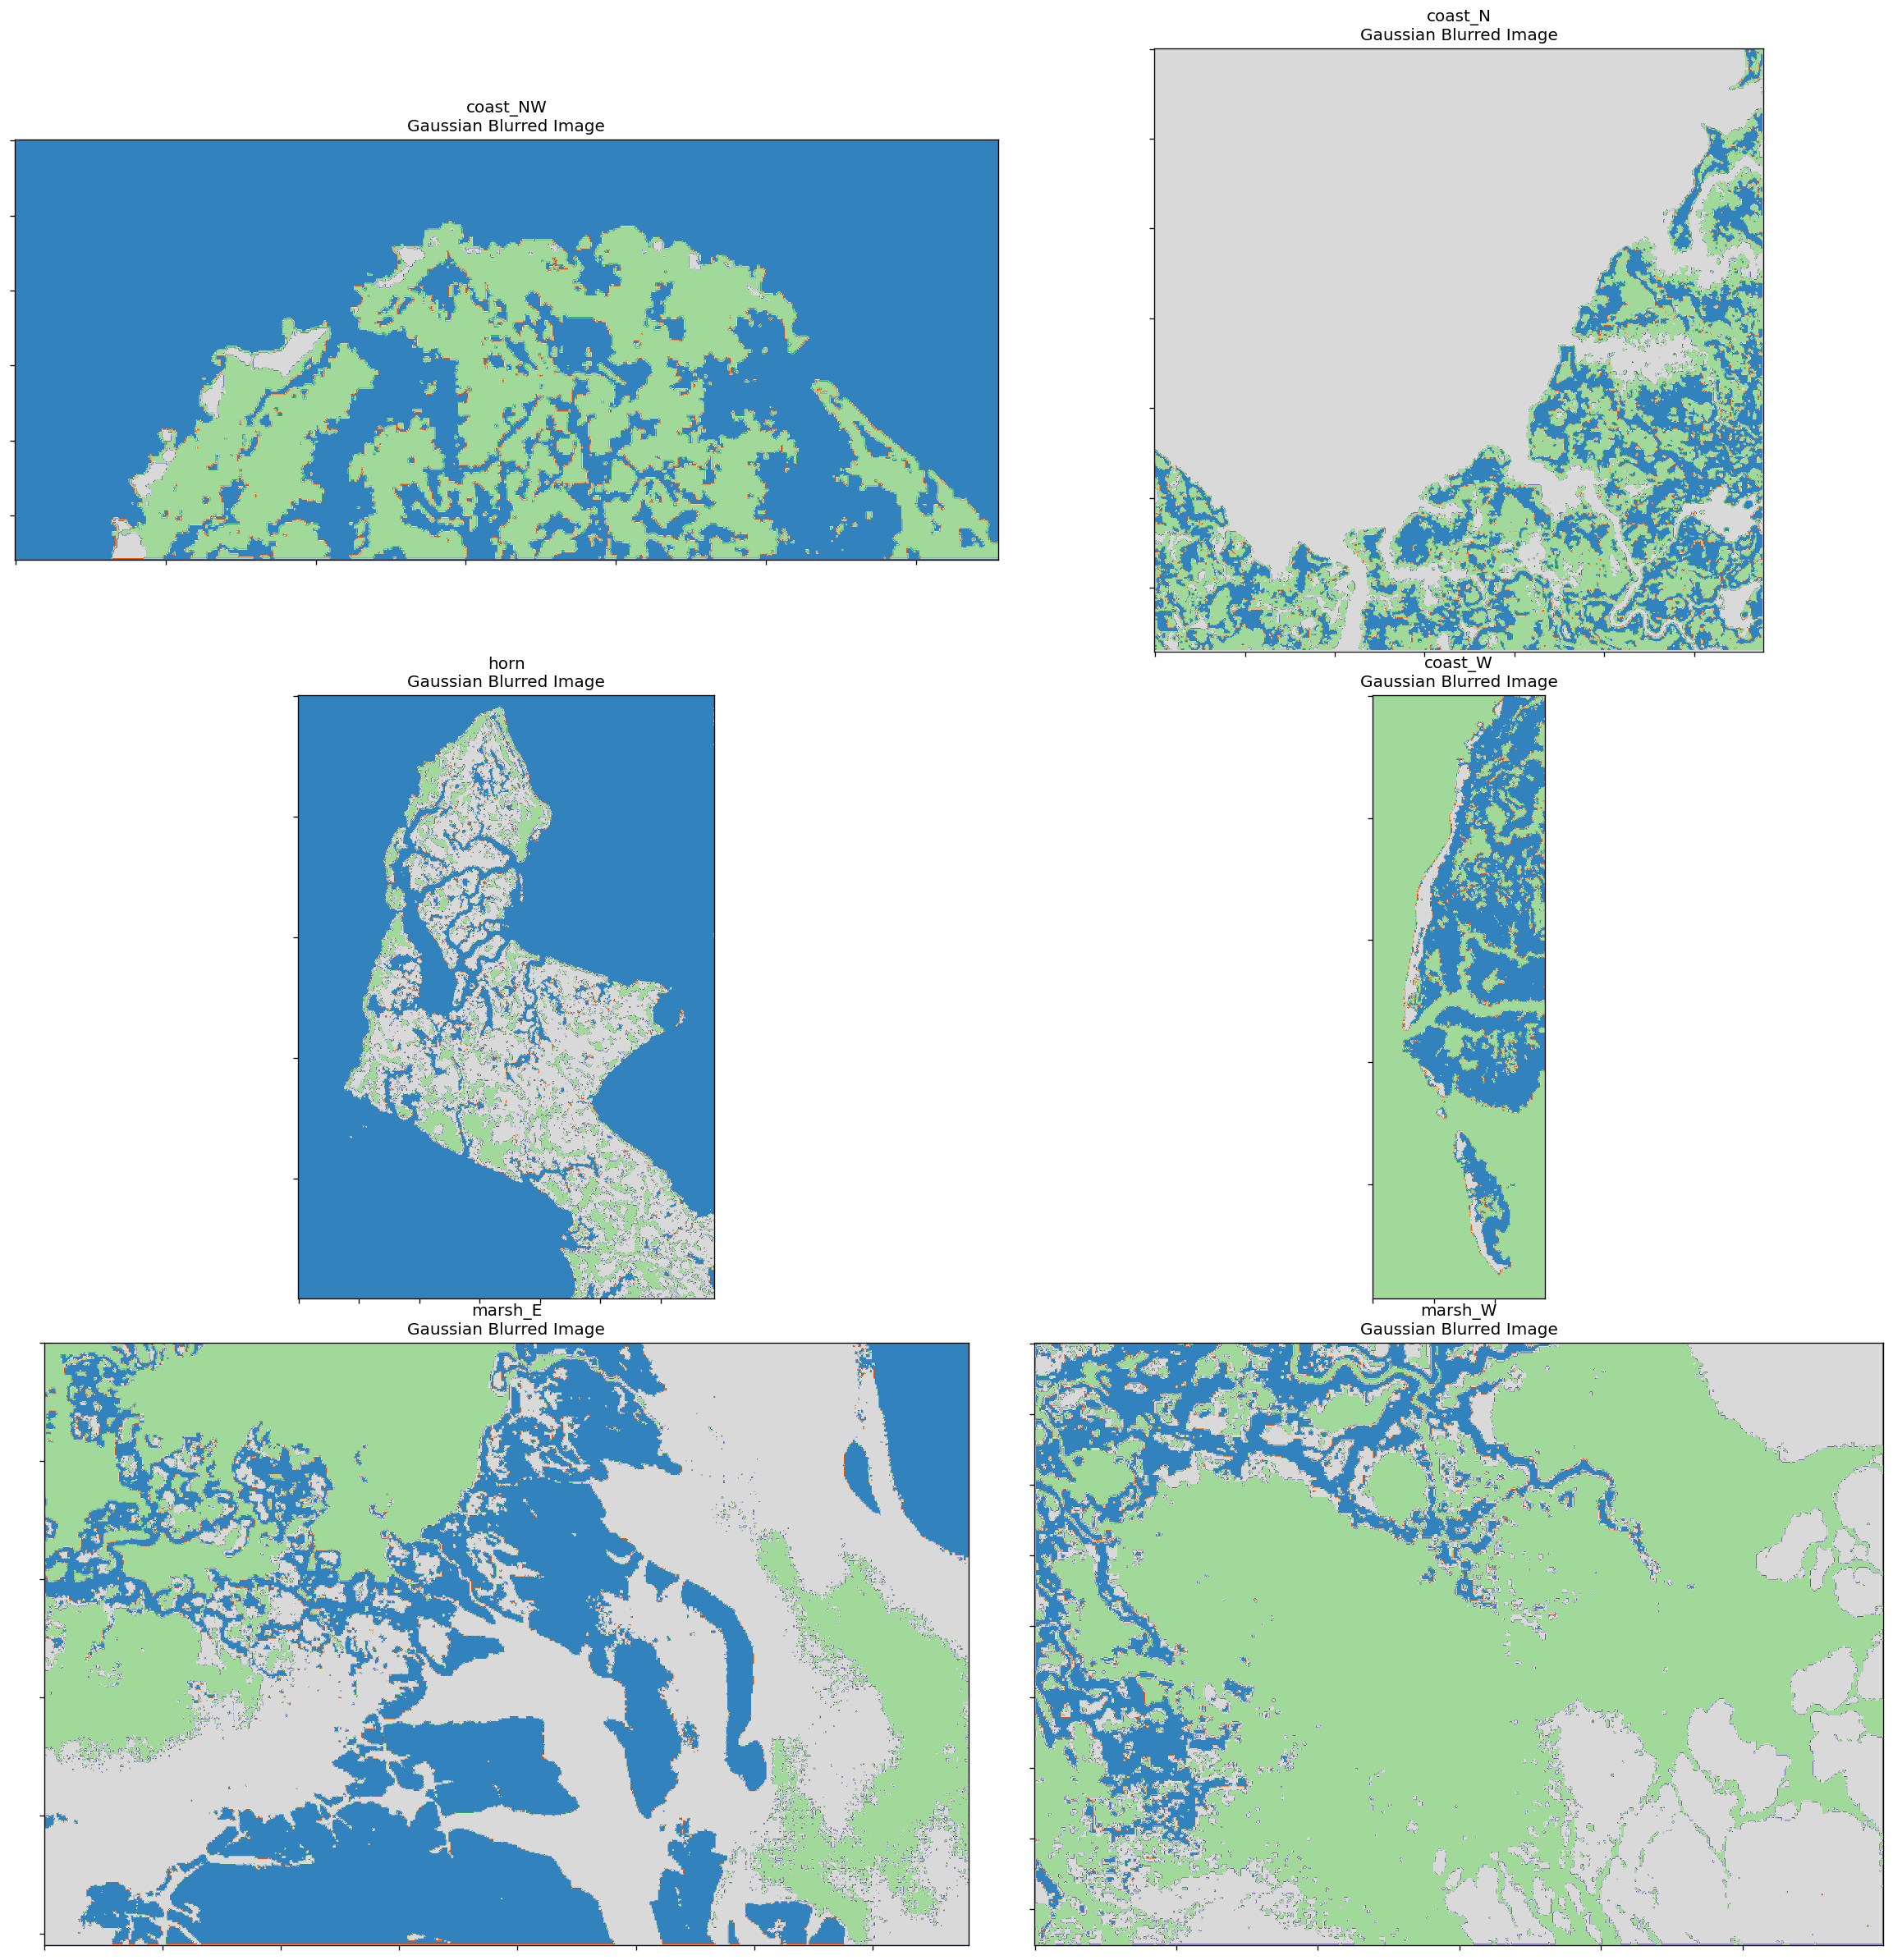

In [38]:
imageSites = []
blurredSites = []

for i, clusters in enumerate(clusterSites):
    clusteredImages = [clusterLabels.reshape(sites[i][j][0].shape) for j, clusterLabels in enumerate(clusters)]
    #blurredImages = [cv.GaussianBlur(clusteredImage, (3,3), 0) for clusteredImage in clusteredImages]
    imageSites.append(clusteredImages)
    #blurredSites.append(blurredImages) 

fig, axs = plt.subplots(3,2, figsize=(20,20), dpi=120)
axs = list(itertools.chain.from_iterable(axs))

labels = times
for i, blur in enumerate(imageSites):
    axs[i].imshow(blur[0], cmap='tab20c')
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
    axs[i].set_title(aoi_list[i]+'\nGaussian Blurred Image')
plt.tight_layout(h_pad=0)
plt.show()

# Remove last subplot as we have an odd number of subplots
#fig.delaxes(axs[-1]) 

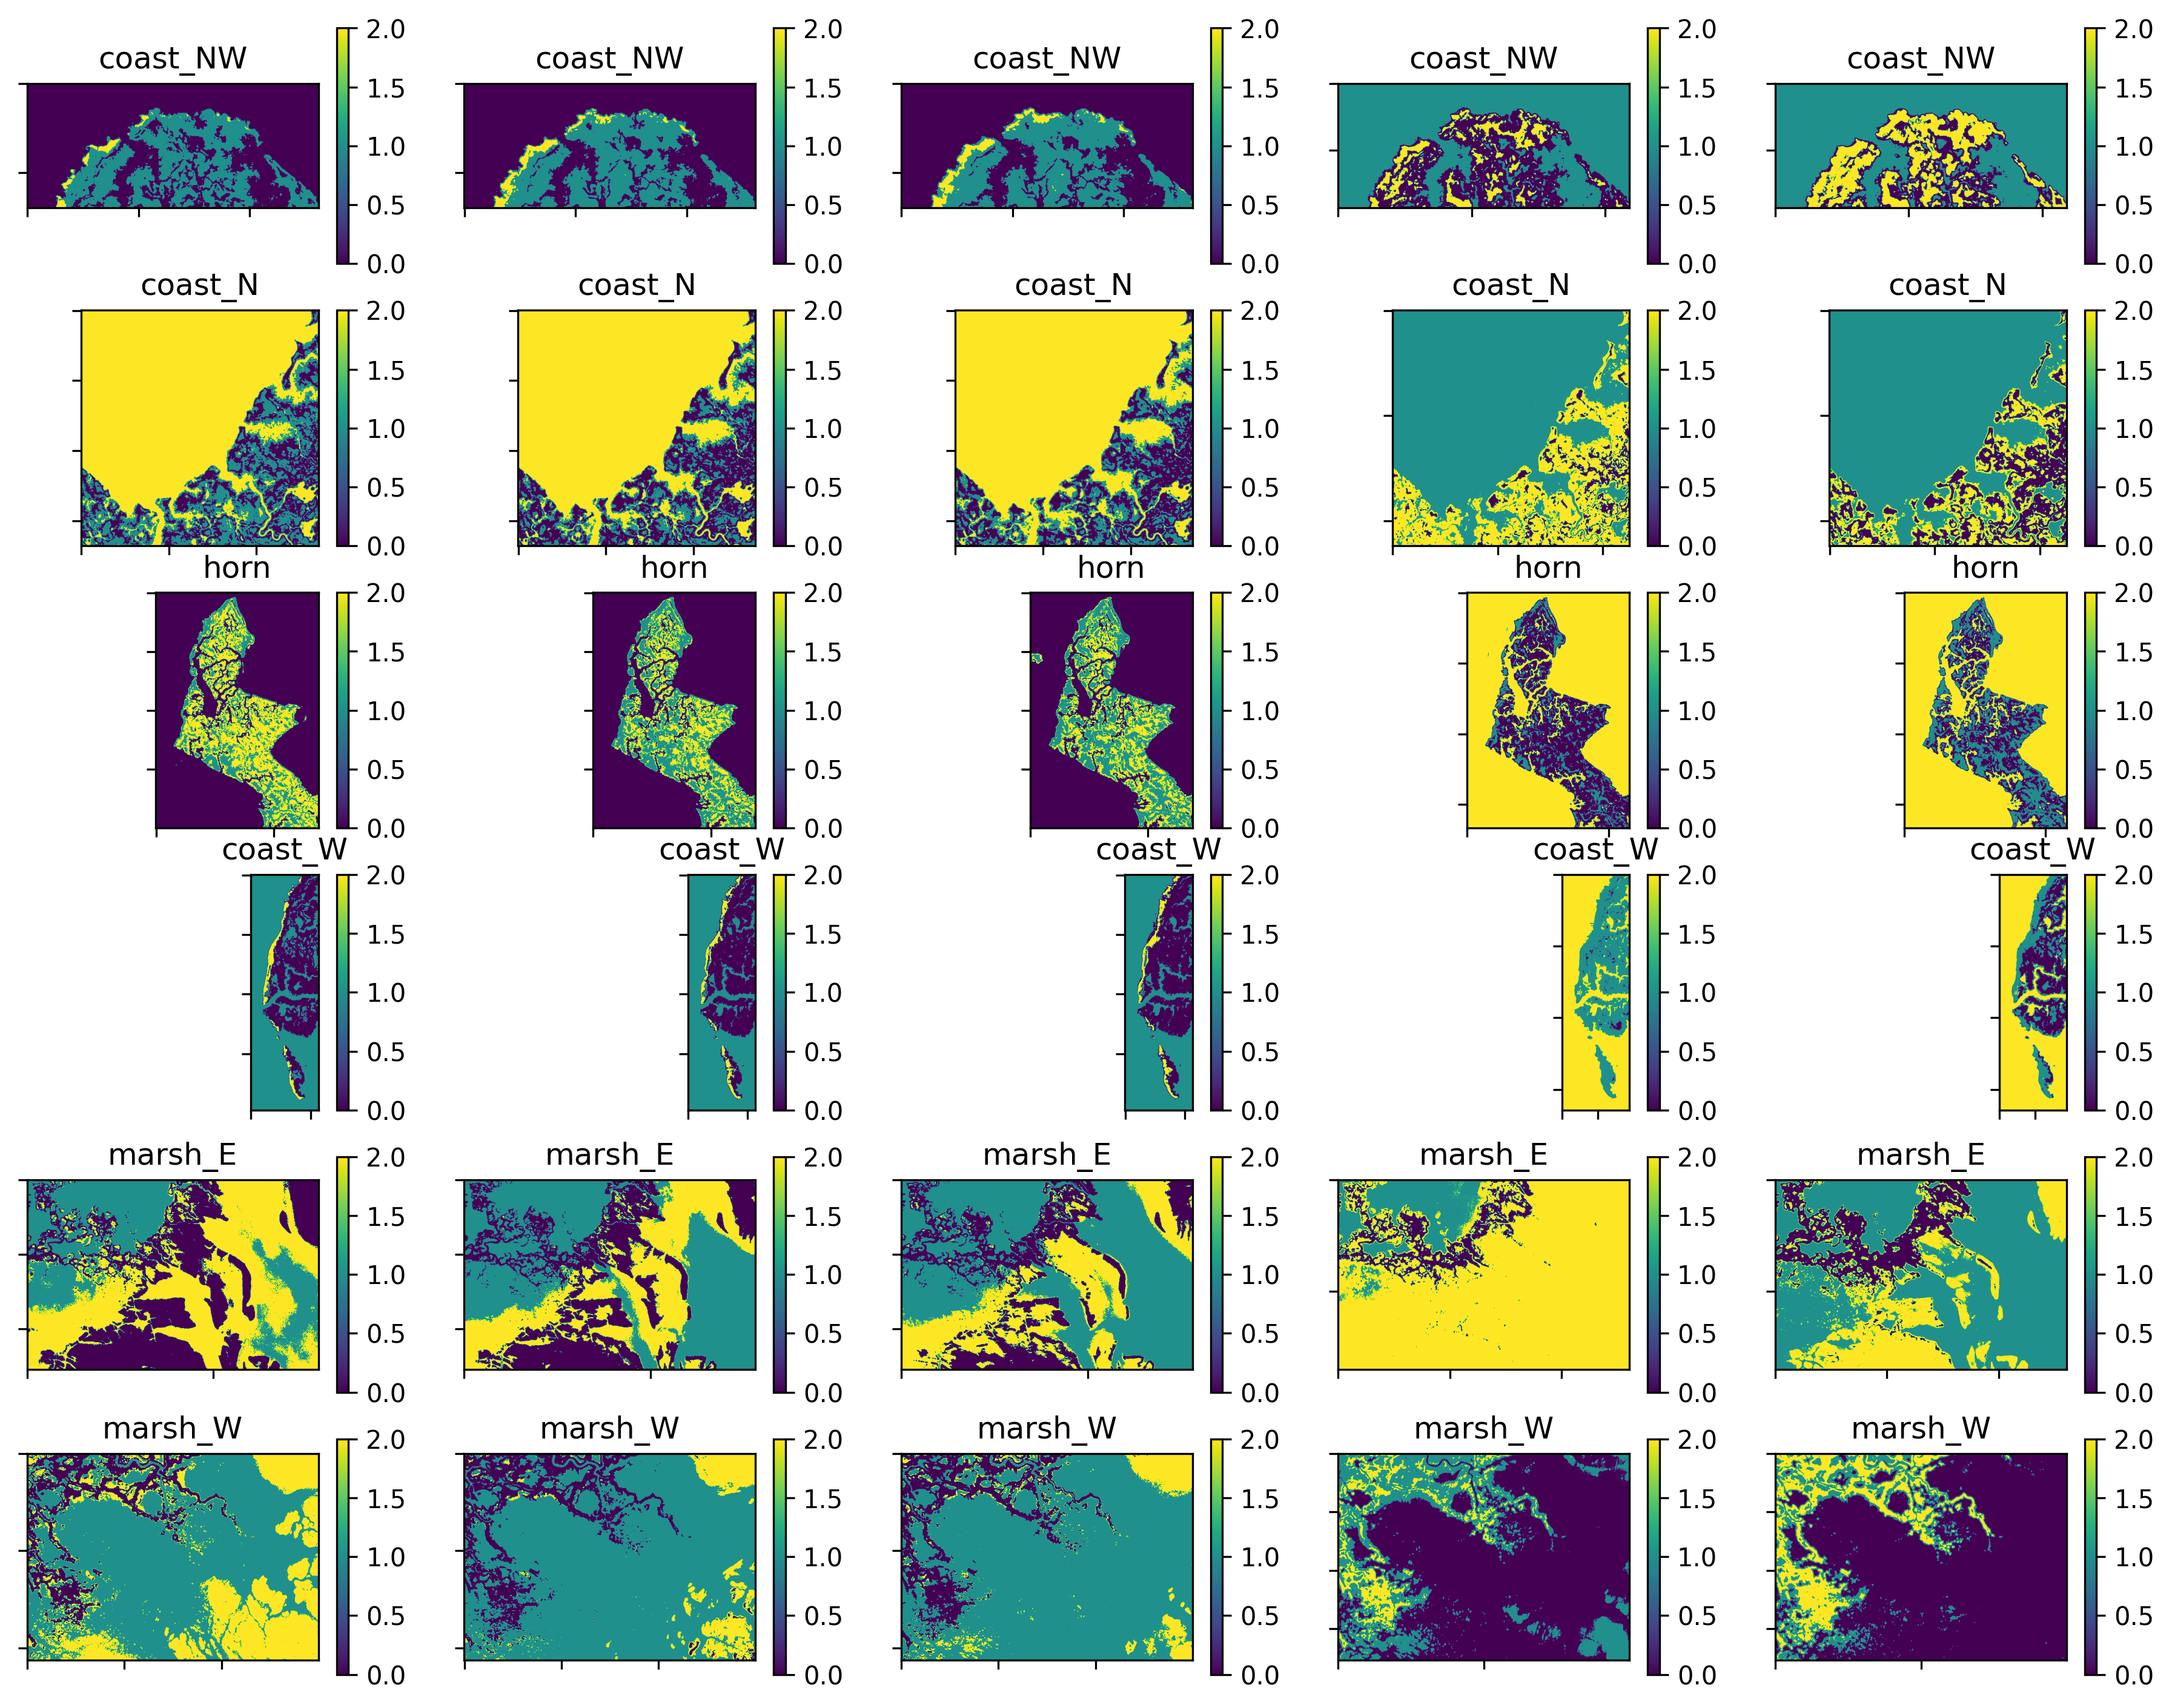

In [39]:
fig, axs = plt.subplots(6,5, figsize=(15,12), dpi=300)
axs = list(itertools.chain.from_iterable(axs))
count = 0
for j,blur in enumerate(imageSites):
    for ob in blur:
        nd = axs[count].imshow(ob)
        axs[count].set_xticklabels([])
        axs[count].set_yticklabels([])
        axs[count].set_title(aoi_list[j])
        plt.colorbar(nd, ax = axs[count])
        count+=1
plt.show()
